# Drone follow me using Kalman Filters

Multi-Object Tracking (MOT) is a core visual ability that humans poses to perform kinetic tasks and coordinate other tasks. The AI community has recognized the importance of MOT via a series of [competitions](https://motchallenge.net). 

In this assignment, the object class is `bicycle` and `car` the ability to track these objects  will be demonstrated using [Kalman Filters](https://en.wikipedia.org/wiki/Kalman_filter).  

## Task 1: Setup your development environment and store the test video locally (10 points)

Your environment must be docker based and you can use any TF2 or PT2 based docker container compatible with your environment. You can also use colab. 

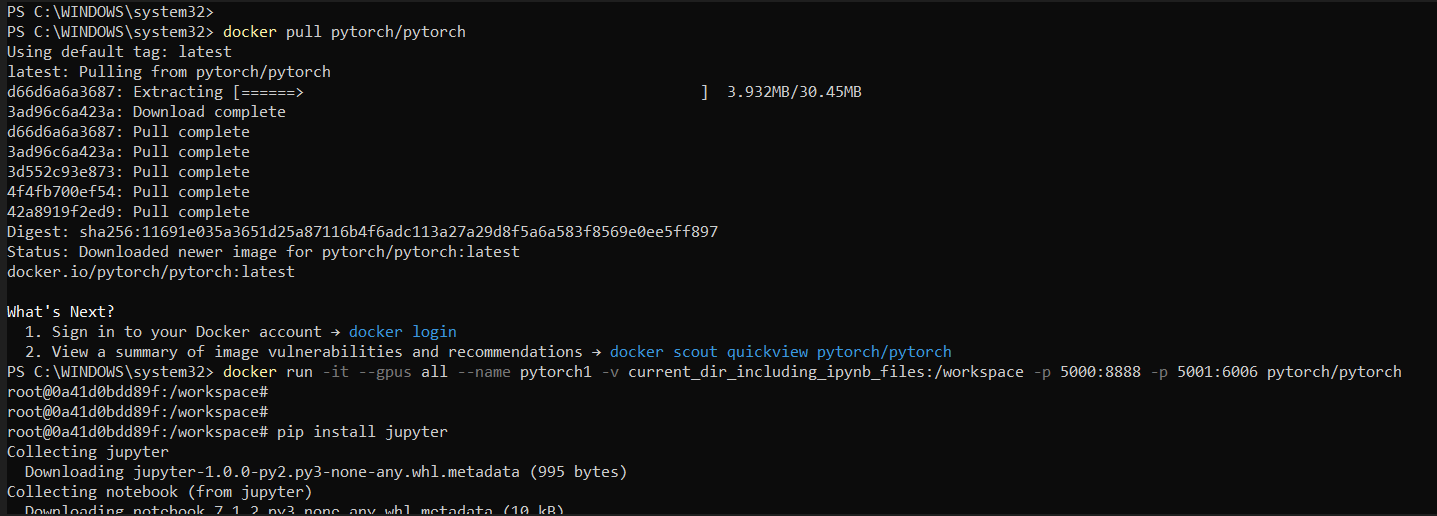
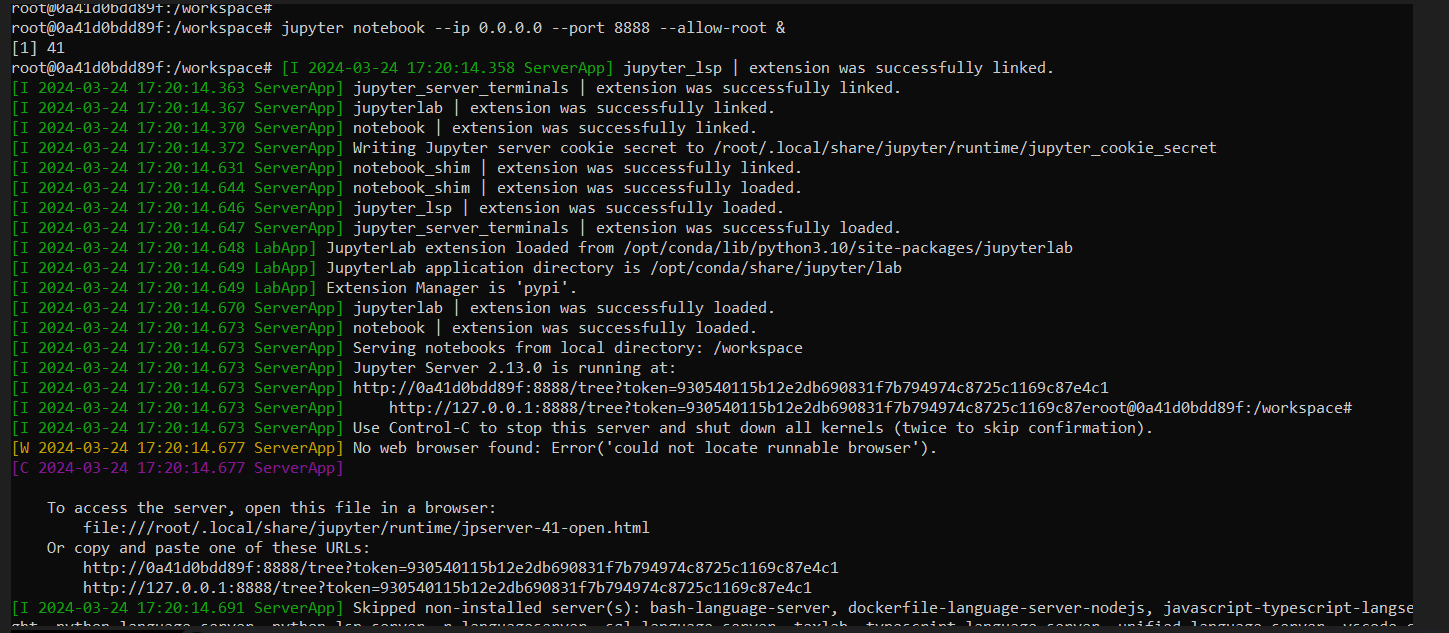
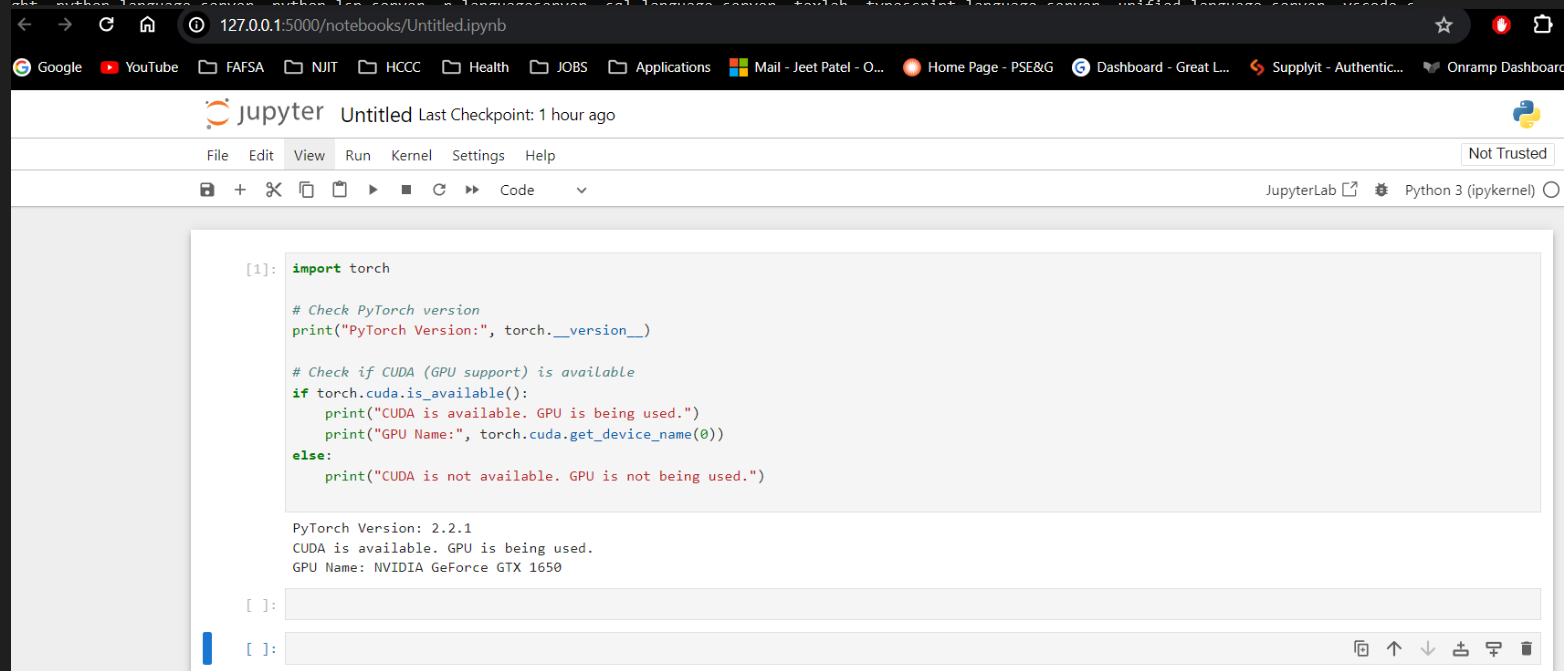

## Task 2: Object Detection (40 points)

Perform object detection on the following videos. 

Split the videos into frames and use an object detector of your choice, in a framework of your choice to detect the cyclists.  

In [5]:
import cv2
import numpy as np
from filterpy.kalman import KalmanFilter

def initialize_kalman_filter():
    kf = KalmanFilter(dim_x=4, dim_z=2)
    kf.F = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]])
    kf.H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
    kf.R *= 10
    kf.P *= 1000
    kf.Q = np.eye(kf.dim_x) * 0.01
    return kf

def select_objects(frame):
    objects = []
    print("Select objects and press ENTER or SPACE when done. Press 'c' to cancel the current selection.")
    while True:
        roi = cv2.selectROI("Frame", frame, fromCenter=False, showCrosshair=True)
        if roi == (0, 0, 0, 0):
            break
        kf = initialize_kalman_filter()
        objects.append([roi, kf, [], None])
    cv2.destroyAllWindows()
    return objects

def track_objects(frame, objects):
    for object in objects:
        roi = object[0]
        tracker = cv2.TrackerCSRT_create()
        tracker.init(frame, roi)
        object[3] = tracker

def update_trackers(objects, frame):
    for object in objects:
        tracker = object[3]
        success, box = tracker.update(frame)
        if success:
            p1 = (int(box[0]), int(box[1]))
            p2 = (int(box[0] + box[2]), int(box[1] + box[3]))
            cv2.rectangle(frame, p1, p2, (0, 255, 0), 2)
            center = (p1[0] + (p2[0] - p1[0]) // 2, p1[1] + (p2[1] - p1[1]) // 2)
            object[2].append(center)
            object[1].update(np.array([[center[0]], [center[1]]]))

def main(video_path):
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    if not ret:
        print("Failed to read the video")
        return
    
    objects = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        update_trackers(objects, frame)
        cv2.imshow("Frame", frame)

        key = cv2.waitKey(30) & 0xFF
        if key == ord('p'):
            selected_objects = select_objects(frame)
            objects.extend(selected_objects)
            track_objects(frame, selected_objects)
        elif key == 27:
            break

    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    video_path = "Cyclist and vehicle Tracking - 2.mp4"
    main(video_path)


## Click on the Youtube link it will open sample video on my youtube channel. I wanted to put the video here but since storage is limited I can not uploaded on Git.
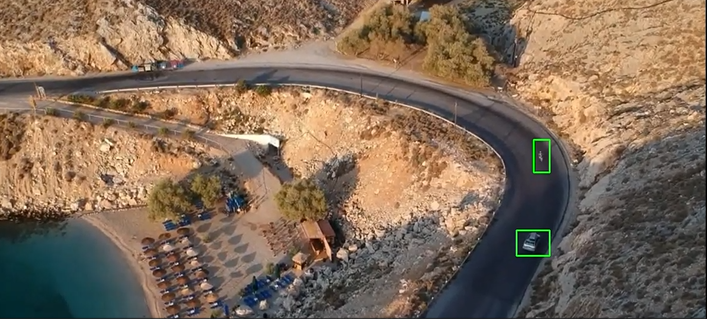
https://youtu.be/bZ4jAOuXk0Y
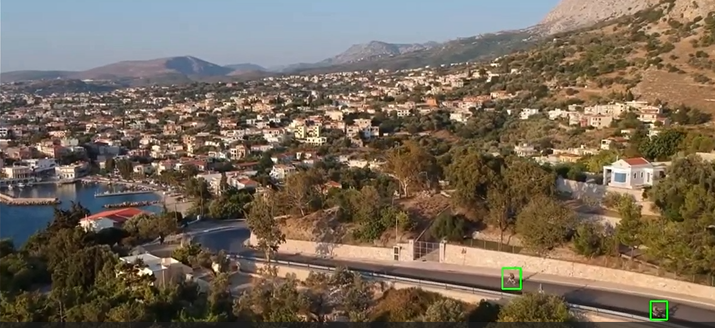
https://youtu.be/yvKXRjNozXs
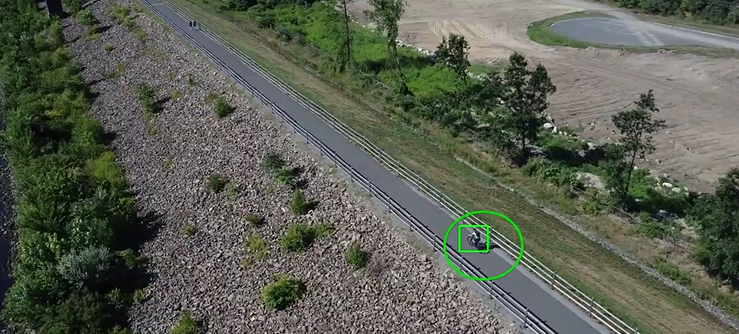
https://youtu.be/RuykFveCeaE

## Task 3: Kalman Filter (50 points)

Use the  [filterpy](https://filterpy.readthedocs.io/en/latest/kalman/KalmanFilter.html) library to implement Kalman filters that will track the cyclist and the vehicle (if present) in the video. You will need to use the detections from the previous task to initialize and run the Kalman filter. 

You need to deliver a video that contains the trajectory of the objects as a line that connects the pixels that the tracker indicated. You can use the `ffmpeg` command line tool and OpenCV to superpose the bounding box of the drone on the video as well as plot its trajectory. 

Suggest methods that you can use to address  false positives and how the tracker can help you in this regard.

You will need to have one Kalman filter to track each of the required and present objects (cyclist and vehicle).


In [ ]:
import cv2
import numpy as np
from filterpy.kalman import KalmanFilter

def load_yolo():
    net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
    with open("coco.names", "r") as f:
        classes = [line.strip() for line in f.readlines()]
    layer_names = net.getLayerNames()

    try:
        output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    except Exception:
        output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

    return net, classes, output_layers


def detect_yolo_objects(frame, net, output_layers):
    height, width, _ = frame.shape
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
    return boxes

def initialize_kalman_filter(x, y):
    kf = KalmanFilter(dim_x=4, dim_z=2)
    kf.F = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]])
    kf.H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
    kf.R = np.eye(2) * 10
    kf.P = np.eye(4) * 500
    kf.Q = np.eye(kf.dim_x) * 0.1
    kf.x = np.array([[x], [y], [0], [0]])
    return kf

def manual_select_objects(frame):
    print("Press 'p' to pause and select objects.")
    objects = []
    while True:
        cv2.imshow("Frame", frame)
        if cv2.waitKey(1) & 0xFF == ord('p'):
            break
    roi = cv2.selectROI("Frame", frame, fromCenter=False, showCrosshair=True)
    cv2.destroyAllWindows()
    if roi == (0, 0, 0, 0):
        return None
    x, y, w, h = roi
    tracker = cv2.TrackerCSRT_create()
    tracker.init(frame, roi)
    kf = initialize_kalman_filter(x + w / 2, y + h / 2)
    return {'roi': roi, 'tracker': tracker, 'kf': kf, 'trajectory': []}

def process_frame(frame, obj):
    success, bbox = obj['tracker'].update(frame)
    if success:
        x, y, w, h = [int(v) for v in bbox]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        kf = obj['kf']
        kf.predict()
        kf.update(np.array([[x + w / 2], [y + h / 2]]))
        obj['trajectory'].append((int(kf.x[0]), int(kf.x[1])))
        if len(obj['trajectory']) > 1:
            for i in range(1, len(obj['trajectory'])):
                cv2.line(frame, obj['trajectory'][i-1], obj['trajectory'][i], (0, 0, 255), 2)
    return frame

def main(video_path):
    net, classes, output_layers = load_yolo()
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    if not ret:
        print("Failed to read the video")
        return
    obj = manual_select_objects(frame)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret or obj is None:
            break
        frame = process_frame(frame, obj)
        cv2.imshow('Frame', frame)
        if cv2.waitKey(30) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    video_path = "Cyclist and vehicle tracking - 1.mp4" 
    main(video_path)


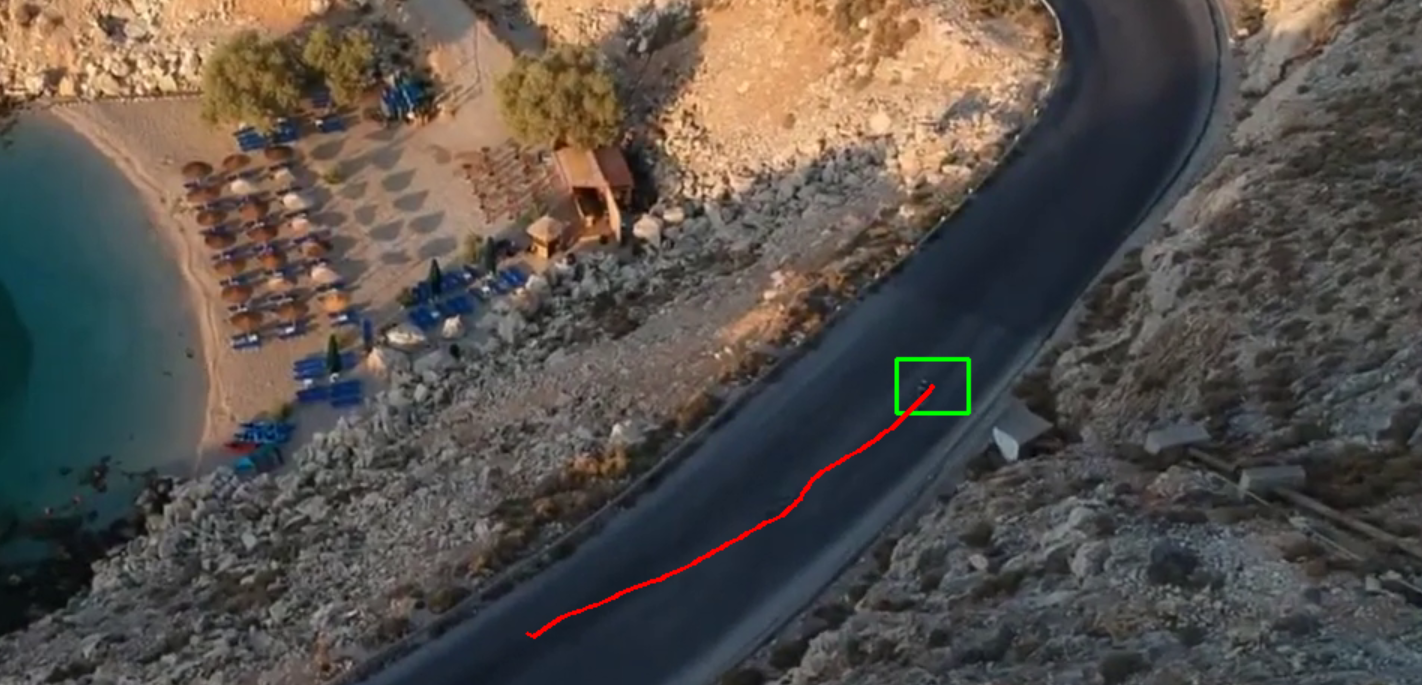
https://youtu.be/o4K1eT_XD4Y

## Extra Bonus (20 points)

The cyclist in the video goes in and out of occlusions. In addition the object is small making detections fairly problematic without finetuning and other optimizations. Fintetuning involves using the pretrained model and training it further using images of cyclists from a training dataset such as VisDrone. At the same time, reducing the number of classes to a much smaller number such as person & bicycle may help. Also some 2 stage detectors may need to be further optimized in terms of parameters for small objects. See this paper for ideas around small object tracking.

In [ ]:
import cv2
import numpy as np
from filterpy.kalman import KalmanFilter

def load_model():
    net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]
    return net, output_layers

def select_roi(frame):
    roi = cv2.selectROI("Frame", frame, fromCenter=False, showCrosshair=True)
    cv2.destroyAllWindows()
    if roi == (0, 0, 0, 0):
        return None
    x, y, w, h = roi
    tracker = cv2.TrackerCSRT_create()
    tracker.init(frame, roi)
    kf = init_kf((x + w / 2), (y + h / 2))
    return {'roi': roi, 'tracker': tracker, 'kf': kf, 'path': []}

def init_kf(x, y):
    kf = KalmanFilter(dim_x=4, dim_z=2)
    kf.F = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]])
    kf.H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
    kf.R = np.eye(2) * 10
    kf.P = np.eye(4) * 500
    kf.Q = np.eye(kf.dim_x) * 0.1
    kf.x = np.array([[x], [y], [0], [0]])
    return kf

def process_frame(frame, obj):
    success, bbox = obj['tracker'].update(frame)
    if success:
        x, y, w, h = [int(v) for v in bbox]
        kf = obj['kf']
        kf.predict()
        kf.update(np.array([[x + w / 2], [y + h / 2]]))
        obj['path'].append((int(kf.x[0][0]), int(kf.x[1][0])))
        for i in range(1, len(obj['path'])):
            cv2.line(frame, obj['path'][i-1], obj['path'][i], (0, 0, 255), 2)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
    return frame

def run(video_path):
    net, output_layers = load_model()
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    if not ret:
        return
    obj = select_roi(frame)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret or obj is None:
            break
        frame = process_frame(frame, obj)
        cv2.imshow('Frame', frame)
        if cv2.waitKey(30) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    video_path = "extra.mp4"  
    run(video_path)


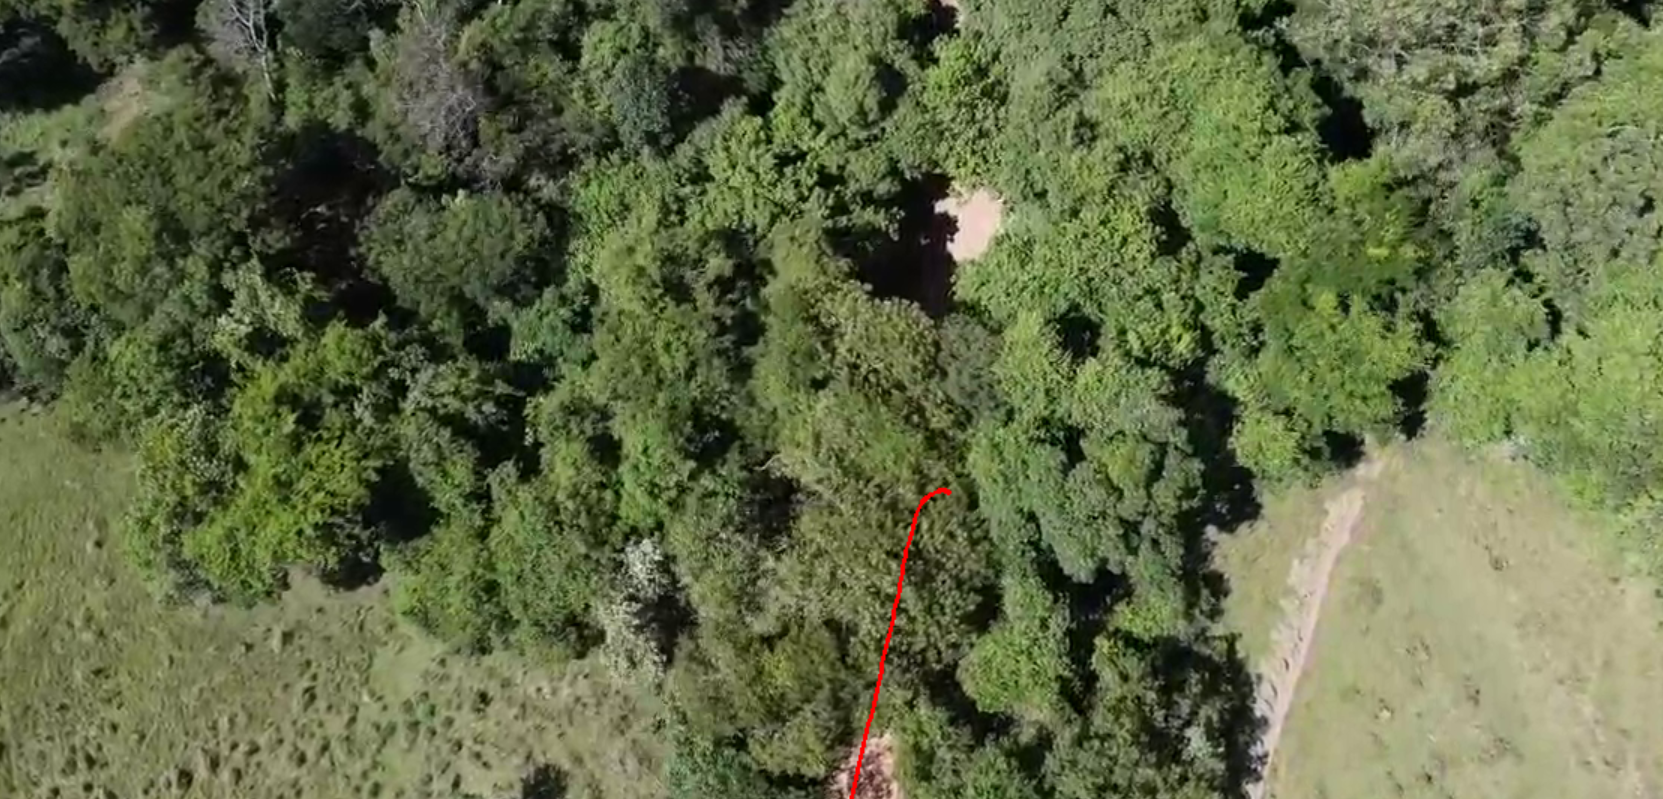
https://youtu.be/wMJ_1Keko3s